## Black-Litterman Model Summary

### Methodology

1. **Reverse Optimization**: Derived implied equilibrium returns (π) from market cap weights using the formula `π = λΣw`
   - Calculated risk aversion coefficient (λ) from market portfolio characteristics
   - These represent what the market "believes" about future returns

2. **Investor Views**: Defined subjective views about future performance
   - View 1: US Large Cap Growth outperforms Value by 3%
   - View 2: Emerging Markets absolute return of 8%
   - View 3: US Growth outperforms International by 4%

3. **Black-Litterman Blending**: Combined equilibrium returns with investor views
   - Views weighted by confidence levels
   - Higher confidence = greater influence on final returns
   - τ parameter controls uncertainty in prior beliefs

4. **Portfolio Optimization**: Used BL expected returns to find optimal allocation
   - Maximized Sharpe ratio subject to long-only constraints
   - Compared to market cap weighted portfolio

### Key Parameters
- **Risk-free rate**: 4%
- **τ (prior uncertainty)**: 0.025
- **λ (risk aversion)**: Derived from market portfolio
- **Historical data**: 5 years of daily returns

### Interpretation
The resulting optimal weights reflect a balance between:
- Market equilibrium (what everyone collectively believes)
- Your subjective views (what you think will happen)
- Statistical uncertainty (confidence in predictions)

Adjust the views, confidence levels, and τ parameter to reflect your market outlook.


In [119]:
%load_ext autoreload
%autoreload 2

import sys, os
import requests
import pandas as pd
import json
import talib
import numpy as np
import time

import yfinance as yf
import warnings
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings('ignore')


SECRET_FP = "./secrets.json"
with open(SECRET_FP, 'r') as file:
    secrets = json.load(file)
API_KEY = secrets['eodhd_api_key']

sys.path.append(r"C:\Users\msands\OneDrive\Documents\code\submodule")
from eodhd import  Chain, ChainHistory, Security, Index
import plot
from plot import ChartStyle
cs = ChartStyle(figsize=(20,8),nyears=1, date_fmt="%Y-%m", grid=False)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Market Implied Equilibrium Weights

In [120]:
# Free float adjusted market cap estimates; Bottom Up Index Aggregate Market Cap
free_float_adj_mkt_cap = {
    # 'SP500': 40_000_000_000_000,      # S&P 500
    # "R1K": 43_000_000_000_000,        # Russell 1000
    "R1KG": 21_500_000_000_000,       # Russell 1000 Growth
    "R1KV": 21_500_000_000_000,       # Russell 1000 Value
    "R2K": 2_200_000_000_000,         # Russell 2000
    # "R2KG": 1_100_000_000_000,        # Russell 2000 Growth
    # "R2KV": 1_100_000_000_000,        # Russell 2000 Value
    # "RMC": 6_500_000_000_000,         # Russell Mid Cap
    "RMCG": 3_250_000_000_000,        # Russell Mid Cap Growth
    "RMCV": 3_250_000_000_000,        # Russell Mid Cap Value
    "INT": 25_000_000_000_000,        # International Developed Markets (MSCI EAFE)
    "EM": 6_000_000_000_000,          # Emerging Markets (MSCI EM)
}

# MSCI ACWI (All Country World Index) country weights are determined by free float-adjusted market capitalization.
msci_acwi_us_alloc = 0.64


In [121]:
us_indices = {k: v for k, v in free_float_adj_mkt_cap.items() if k not in ['INT', 'EM']}
intl_indices = {k: v for k, v in free_float_adj_mkt_cap.items() if k in ['INT', 'EM']}

total_us_mkt_cap = sum(us_indices.values())
total_intl_mkt_cap = sum(intl_indices.values())

weights = {}

# US indices: scale to msci_acwi_us_alloc
for ticker, mkt_cap in us_indices.items():
    weights[ticker] = (mkt_cap / total_us_mkt_cap) * msci_acwi_us_alloc * 100

# International & EM indices: scale to remaining allocation
intl_alloc = 1 - msci_acwi_us_alloc
for ticker, mkt_cap in intl_indices.items():
    weights[ticker] = (mkt_cap / total_intl_mkt_cap) * intl_alloc * 100

df_weights = pd.DataFrame({
    'Ticker': list(weights.keys()),
    'Market Cap': [free_float_adj_mkt_cap[t] for t in weights.keys()],
    'Weight (%)': list(weights.values())
})

df_weights # market inferred equilibrium weights

,Ticker,Market Cap,Weight (%)
0,R1KG,21500000000000,26.615087
1,R1KV,21500000000000,26.615087
2,R2K,2200000000000,2.723404
3,RMCG,3250000000000,4.023211
4,RMCV,3250000000000,4.023211
5,INT,25000000000000,29.032258
6,EM,6000000000000,6.967742


# Historical Returns and Volatility

In [122]:
etf_map = {
    "R1KG": "IWF",  # Russell 1000 Growth Index
    "R1KV": "IWD",  # Russell 1000 Value Index
    "R2K": "IWM",   # Russell 2000 Index
    "RMCG": "IWP",  # Russell Midcap Growth Index
    "RMCV": "IWS",  # Russell Midcap Value Index
    "INT": "EFA",   # MSCI EAFE Index (International Developed)
    "EM": "EEM",    # MSCI Emerging Markets Index
}

sec = Security(ticker=list(etf_map.values()), start='2000-01-01')

# Create reverse mapping (ETF ticker -> Index name)
reverse_map = {v: k for k, v in etf_map.items()}

prices = sec.prices.rename(columns=reverse_map)
returns = sec.returns.rename(columns=reverse_map)

returns.index = pd.to_datetime(returns.index)

In [123]:
def get_first_valid_dates(df):
    first_dates = {}
    for col in df.columns:
        first_valid_idx = df[col].first_valid_index()
        first_dates[col] = first_valid_idx
    
    result_df = pd.DataFrame({
        'Column': list(first_dates.keys()),
        'First Valid Date': list(first_dates.values())
    })
    return result_df

get_first_valid_dates(returns)

,Column,First Valid Date
0,EM,2003-04-14
1,INT,2003-04-14
2,R1KV,2003-04-14
3,R1KG,2003-04-14
4,R2K,2003-04-14
5,RMCG,2003-04-14
6,RMCV,2003-04-14


## Returns

In [124]:
# Calculate comprehensive return statistics
stats_list = []

for col in returns.columns:
    col_returns = returns[col].dropna()
    
    # Calculate number of years
    n_years = len(col_returns) / 252
    
    # Total compound return
    total_compound_return = (1 + col_returns).prod() - 1
    
    # Annualized total return (CAGR)
    annualized_return = (1 + total_compound_return) ** (1 / n_years) - 1
    
    # Average annual return (arithmetic mean)
    avg_annual_return = col_returns.mean() * 252
    
    annual_returns_by_year = []
    years = col_returns.index.year.unique()
    
    for year in years:
        year_returns = col_returns[col_returns.index.year == year]
        annual_ret = (1 + year_returns).prod() - 1
        annual_returns_by_year.append(annual_ret)
    
    annual_returns_series = pd.Series(annual_returns_by_year)
    
    stats_list.append({
        'Ticker': col,
        'Total Compound Return (%)': total_compound_return * 100,
        'Annualized Return (CAGR) (%)': annualized_return * 100,
        'Average Annual Return (%)': avg_annual_return * 100,
        'Min Annual Return (%)': annual_returns_series.min() * 100,
        '25th Percentile Annual Return (%)': annual_returns_series.quantile(0.25) * 100,
        'Median Annual Return (%)': annual_returns_series.median() * 100,
        '75th Percentile Annual Return (%)': annual_returns_series.quantile(0.75) * 100,
        'Max Annual Return (%)': annual_returns_series.max() * 100,
        'Years of Data': n_years
    })

df_return_stats = pd.DataFrame(stats_list)
df_return_stats = df_return_stats.round(2)

df_return_stats


,Ticker,Total Compound Return (%),Annualized Return (CAGR) (%),Average Annual Return (%),Min Annual Return (%),25th Percentile Annual Return (%),Median Annual Return (%),75th Percentile Annual Return (%),Max Annual Return (%),Years of Data
0,EM,215.80,5.23,8.80,-60.25,-5.22,10.11,26.34,63.34,22.57
1,INT,232.97,5.47,7.49,-47.19,-1.38,10.53,20.35,46.46,22.57
2,R1KV,403.66,7.43,8.99,-41.97,-2.47,13.15,16.30,32.80,22.57
3,R1KG,919.78,10.84,12.21,-42.41,4.80,11.95,29.68,39.94,22.57
4,R2K,344.15,6.83,9.47,-40.77,-0.39,11.81,18.00,49.42,22.57
5,RMCG,610.11,9.07,10.99,-49.41,4.57,10.87,23.97,40.33,22.57
6,RMCV,498.08,8.25,10.02,-43.44,-3.25,12.77,21.87,41.21,22.57


## Volatility

In [125]:
N_SLICEES = 5
vol_stats_list = []

for col in returns.columns:
    col_returns = returns[col].dropna()
    
    # Calculate annualized volatility metrics
    total_vol = col_returns.std() * np.sqrt(252)
    avg_vol = col_returns.rolling(window=252).std().mean() * np.sqrt(252)
    
    # Split data into 5 time segments
    n_obs = len(col_returns)
    segment_size = n_obs // N_SLICEES
    
    segment_vols = {}
    for i in range(N_SLICEES):
        start_idx = i * segment_size
        if i == N_SLICEES - 1:  # Last segment includes any remainder
            end_idx = n_obs
        else:
            end_idx = (i + 1) * segment_size
        
        segment_data = col_returns.iloc[start_idx:end_idx]
        segment_vol = segment_data.std() * np.sqrt(252)
        
        # Get date range for segment
        start_date = segment_data.index[0].strftime('%Y-%m')
        end_date = segment_data.index[-1].strftime('%Y-%m')
        
        segment_vols[f'Period {i+1} ({start_date} to {end_date})'] = segment_vol * 100
    
    vol_data = {
        'Ticker': col,
        'Total Volatility (%)': total_vol * 100,
        'Average Rolling Volatility (%)': avg_vol * 100,
    }
    vol_data.update(segment_vols)
    
    vol_stats_list.append(vol_data)

df_vol_stats = pd.DataFrame(vol_stats_list)
df_vol_stats = df_vol_stats.round(2)

print("Volatility Statistics:")
df_vol_stats


Volatility Statistics:


,Ticker,Total Volatility (%),Average Rolling Volatility (%),Period 1 (2003-04 to 2007-10),Period 2 (2007-10 to 2012-04),Period 3 (2012-04 to 2016-10),Period 4 (2016-10 to 2021-05),Period 5 (2021-05 to 2025-11)
0,EM,27.22,24.63,22.94,44.40,19.44,22.34,18.16
1,INT,20.73,18.94,14.40,33.08,15.99,18.04,16.30
2,R1KV,19.04,17.06,12.03,29.28,13.23,20.17,15.13
3,R1KG,19.56,18.04,12.42,25.48,13.38,21.33,21.82
4,R2K,23.88,22.41,17.90,33.88,16.42,24.35,22.83
5,RMCG,21.39,19.75,14.36,29.72,14.48,21.72,22.73
6,RMCV,20.38,18.38,12.24,30.69,13.82,21.98,17.68


## Sharpe

In [126]:
N_SLICEES = 5
risk_free_rate = 0.04
sharpe_stats_list = []

for col in returns.columns:
    col_returns = returns[col].dropna()
    
    # Calculate total period Sharpe ratio
    total_return = col_returns.mean() * 252
    total_vol = col_returns.std() * np.sqrt(252)
    total_sharpe = (total_return - risk_free_rate) / total_vol
    
    # Split data into 5 time segments
    n_obs = len(col_returns)
    segment_size = n_obs // N_SLICEES
    
    segment_sharpes = {}
    for i in range(N_SLICEES):
        start_idx = i * segment_size
        if i == N_SLICEES - 1:  # Last segment includes any remainder
            end_idx = n_obs
        else:
            end_idx = (i + 1) * segment_size
        
        segment_data = col_returns.iloc[start_idx:end_idx]
        segment_return = segment_data.mean() * 252
        segment_vol = segment_data.std() * np.sqrt(252)
        segment_sharpe = (segment_return - risk_free_rate) / segment_vol
        
        # Get date range for segment
        start_date = segment_data.index[0].strftime('%Y-%m')
        end_date = segment_data.index[-1].strftime('%Y-%m')
        
        segment_sharpes[f'Period {i+1} ({start_date} to {end_date})'] = segment_sharpe
    
    sharpe_data = {
        'Ticker': col,
        'Total Sharpe Ratio': total_sharpe,
    }
    sharpe_data.update(segment_sharpes)
    
    sharpe_stats_list.append(sharpe_data)

df_sharpe_stats = pd.DataFrame(sharpe_stats_list)
df_sharpe_stats = df_sharpe_stats.round(2)

print("Sharpe Ratio Statistics:")
df_sharpe_stats

Sharpe Ratio Statistics:


,Ticker,Total Sharpe Ratio,Period 1 (2003-04 to 2007-10),Period 2 (2007-10 to 2012-04),Period 3 (2012-04 to 2016-10),Period 4 (2016-10 to 2021-05),Period 5 (2021-05 to 2025-11)
0,EM,0.18,1.37,-0.16,-0.23,0.28,-0.12
1,INT,0.17,1.34,-0.34,0.08,0.32,0.14
2,R1KV,0.26,1.08,-0.23,0.58,0.41,0.19
3,R1KG,0.42,0.71,-0.08,0.58,0.79,0.44
4,R2K,0.23,0.83,-0.10,0.39,0.45,-0.06
5,RMCG,0.33,1.03,-0.08,0.44,0.65,0.09
6,RMCV,0.30,1.32,-0.11,0.61,0.37,0.05


# Covariance

In [127]:
# Calculate annualized returns and covariance matrix for Black-Litterman
# The views in the Black-Litterman model are expressed over the same time horizon as your covariance matrix and expected returns

annual_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
corr_matrix = returns.corr()

print("Annual Expected Returns:")
print(annual_returns)
print("\nCovariance Matrix:")
print(cov_matrix)
print("\nCorrelation Matrix:")
print(corr_matrix)

Annual Expected Returns:
ticker
EM      0.088022
INT     0.074877
R1KV    0.089854
R1KG    0.122106
R2K     0.094748
RMCG    0.109859
RMCV    0.100194
dtype: float64

Covariance Matrix:
ticker        EM       INT      R1KV      R1KG       R2K      RMCG      RMCV
ticker                                                                      
EM      0.074098  0.048820  0.041505  0.041111  0.049181  0.045529  0.043639
INT     0.048820  0.042964  0.034524  0.033313  0.039945  0.036465  0.036055
R1KV    0.041505  0.034524  0.036245  0.032419  0.040861  0.035966  0.037645
R1KG    0.041111  0.033313  0.032419  0.038256  0.039878  0.039483  0.034343
R2K     0.049181  0.039945  0.040861  0.039878  0.057016  0.046438  0.045363
RMCG    0.045529  0.036465  0.035966  0.039483  0.046438  0.045740  0.039478
RMCV    0.043639  0.036055  0.037645  0.034343  0.045363  0.039478  0.041552

Correlation Matrix:
ticker        EM       INT      R1KV      R1KG       R2K      RMCG      RMCV
ticker                 

# Reverse Optimization

How π = λΣw Works

### The Calculation Steps

1. **Σ @ w_mkt** → Multiplies the 7×7 covariance matrix by the 7×1 weight vector → produces a 7×1 vector representing the **marginal contribution to portfolio risk** for each asset

2. **lambda_risk_aversion ×** → Scales this by the risk aversion coefficient → converts risk contributions into **expected return premiums**

---

### Equilibrium Intuition

In equilibrium, assets with higher contributions to portfolio risk must offer higher expected returns to compensate investors. The formula says:

- **Assets that are more volatile** (high variance) → higher implied returns
- **Assets that correlate positively with the portfolio** → higher implied returns
- **Assets with larger market weights** → already reflect equilibrium pricing

**Note on market weights:** Assets with larger market cap weights don't necessarily need higher expected returns - their current weights already represent the market's equilibrium assessment of their risk/return profile. If an asset has a large market cap weight, there are two possible reasons:

1. It offers high expected returns (investors want to hold a lot of it)
2. It has low risk or diversification benefits (it's "safe" to hold a lot of it)

The market weight itself is the **outcome** of equilibrium pricing - it already incorporates all the information about risk and return that investors collectively believe.

---

### Example

If emerging markets (EM) has high volatility and positive correlation with the rest of the portfolio, the formula will assign it a higher implied return to justify investors holding it at its current market weight.

In [128]:
# Step 1: Reverse Optimization - Derive Implied Equilibrium Returns
# Using the formula: π = λ * Σ * w_mkt
# where λ is the risk aversion coefficient

# Convert weights from percentage to decimal
w_mkt = (df_weights.set_index('Ticker')['Weight (%)']/100).values

# Calculate market variance
market_variance = w_mkt.T @ cov_matrix.values @ w_mkt

# Estimate risk aversion coefficient (λ) using market Sharpe ratio approach
# Typically ranges from 2-4
risk_free_rate = 0.04  # Assume 4% risk-free rate (US10Y)
market_return = (w_mkt.T @ annual_returns.values)
lambda_risk_aversion = (market_return - risk_free_rate) / market_variance
# risk aversion treated as a single scalar reflecting how much extra return investors require for taking additional risk. This implementation does not use asset specific risk aversion.

print(f"Risk Aversion Coefficient (λ): {lambda_risk_aversion:.4f}")
print(f"Market Return: {market_return:.4%}")
print(f"Market Variance: {market_variance:.4f}")
print(f"Market Stdev: {np.sqrt(market_variance):.4f}")

# Derive implied equilibrium returns (π)
pi = lambda_risk_aversion * cov_matrix.values @ w_mkt

# Create dataframe with implied returns
df_implied_returns = pd.DataFrame({
    'Ticker': df_weights['Ticker'],
    'Market Weight (%)': df_weights['Weight (%)'],
    'Implied Return (%)': pi * 100
})

print("\nImplied Equilibrium Returns (from Reverse Optimization):")
df_implied_returns


Risk Aversion Coefficient (λ): 1.1939
Market Return: 9.3403%
Market Variance: 0.0447
Market Stdev: 0.2115

Implied Equilibrium Returns (from Reverse Optimization):


,Ticker,Market Weight (%),Implied Return (%)
0,R1KG,26.615087,6.415429
1,R1KV,26.615087,4.944381
2,R2K,2.723404,4.445371
3,RMCG,4.023211,4.499714
4,RMCV,4.023211,5.417163
5,INT,29.032258,5.048777
6,EM,6.967742,4.751485


## Scalar vs. Asset-Specific Risk Aversion

The choice between scalar vs. array risk aversion involves important tradeoffs:

### Pro:
- Captures heterogeneous investor risk preferences across asset classes (e.g., institutions may be more risk-averse to emerging markets than domestic equities)
- Can reflect market segmentation where different investor bases dominate different assets
- Allows modeling of risk budgeting frameworks where risk tolerance varies by asset category

### Cons:
- No clear market observable to estimate individual λᵢ values - you'd need to make subjective assumptions
- Loss of interpretability: a single λ has clear economic meaning (market price of risk), but asset-specific values are harder to justify
- Violates the assumption of a representative investor with consistent preferences across all assets
- In standard CAPM/equilibrium theory, all investors face the same efficient frontier, implying a single market-wide risk aversion
- Can lead to arbitrage opportunities in theory (why would rational investors have different risk aversion for the same dollar of risk?)

---

The Black-Litterman model already allows you to express asset-specific views through the P and Q matrices. If you believe certain assets deserve different treatment, you can express that through higher-confidence views rather than modifying the equilibrium framework.

The power of Black-Litterman is separating equilibrium (market consensus) from your subjective views. Using asset-specific risk aversion muddies this distinction and essentially bakes your views into the "neutral" equilibrium, which defeats the model's elegance.

In [129]:
# Test: Reverse the reverse optimization to verify we get back to the original weights
# Given the implied equilibrium returns (π), solve for weights that would produce them
# Using mean-variance optimization: max w'π - (λ/2)w'Σw subject to w'1 = 1
from scipy.optimize import minimize

def objective_reverse(w, pi, Sigma, lambda_risk):
    """Objective function to minimize: -(w'π - (λ/2)w'Σw)"""
    return -(w.T @ pi - (lambda_risk / 2) * w.T @ Sigma @ w)

# Constraints and bounds
n_assets = len(pi)
constraints_test = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # weights sum to 1
]
bounds_test = tuple((0, 1) for _ in range(n_assets))
initial_guess_test = np.array([1/n_assets] * n_assets)

# Solve for weights given equilibrium returns
result_test = minimize(
    objective_reverse,
    initial_guess_test,
    args=(pi, cov_matrix.values, lambda_risk_aversion),
    method='SLSQP',
    bounds=bounds_test,
    constraints=constraints_test,
    options={'ftol': 1e-12, 'maxiter': 1000}
)

# Extract calculated weights
calculated_weights = result_test.x

# Compare with original market weights
df_weight_test = pd.DataFrame({
    'Ticker': ticker_list,
    'Original Market Weight': w_mkt,
    'Calculated Weight': calculated_weights,
    'Difference': calculated_weights - w_mkt,
    'Absolute Error': np.abs(calculated_weights - w_mkt)
})

print("Weight Verification Test:")
display(df_weight_test)
print(f"\nMaximum Absolute Error: {df_weight_test['Absolute Error'].max():.6f}")
print(f"Mean Absolute Error: {df_weight_test['Absolute Error'].mean():.6f}")
print(f"Test {'PASSED' if df_weight_test['Absolute Error'].max() < 0.001 else 'FAILED'} (threshold: 0.001)")


Weight Verification Test:


,Ticker,Original Market Weight,Calculated Weight,Difference,Absolute Error
0,R1KG,0.266151,0.266151,1.039022e-07,1.039022e-07
1,R1KV,0.266151,0.266150,-5.031852e-07,5.031852e-07
2,R2K,0.027234,0.027240,5.628593e-06,5.628593e-06
3,RMCG,0.040232,0.040230,-1.928512e-06,1.928512e-06
4,RMCV,0.040232,0.040234,2.196299e-06,2.196299e-06
5,INT,0.290323,0.290325,2.041681e-06,2.041681e-06
6,EM,0.069677,0.069670,-7.538778e-06,7.538778e-06



Maximum Absolute Error: 0.000008
Mean Absolute Error: 0.000003
Test PASSED (threshold: 0.001)


# Investor Views

In [130]:
# Step 2: Define Investor Views (P matrix and Q vector)
# These are subjective views about expected returns

# Example views - you can customize these based on your market outlook:
# View 1: US Large Cap Growth (R1KG) will outperform US Large Cap Value (R1KV) by 3%
# View 2: Emerging Markets (EM) will return 8% absolute
# View 3: International Developed (INT) will underperform US markets by 2%

# P matrix: picks out the assets in each view
# Q vector: the expected returns according to the views
# Omega: diagonal matrix of view uncertainties (variances)

views = {
    'View 1: R1KG outperforms R1KV by 5%': {
        'assets': ['R1KG', 'R1KV'],
        'weights': [1, -1],
        'return': 0.05,
        'confidence': 0.75  
    },
    'View 2: 60/40 R1KG/R1KV outperforms INT by 4%': {
        'assets': ['R1KG', 'R1KV', 'INT'],
        'weights': [0.6, 0.4, -1],  # (60% R1KG + 40% R1KV) - 100% INT
        'return': 0.04,
        'confidence': 0.75
    },
    'View 3: 60/40 R1KG/R1KV outperforms R2k by 5%': {
        'assets': ['R1KG', 'R1KV', 'R2K'],
        'weights': [0.6, 0.4, -1],  # (60% R1KG + 40% R1KV) - 100% R2K
        'return': 0.05,
        'confidence': 0.75
    },
    'View 4: 60/40 RMCG/RMCV outperforms R2K by 2.5%': {
        'assets': ['RMCG', 'RMCV', 'R2K'],
        'weights': [0.6, 0.4, -1],  # (60% RMCG + 40% RMCV) - 100% R2K
        'return': 0.025,
        'confidence': 0.75 
    },  
    'View 5: EM outperforms INT by 3%': {
        'assets': ['EM', 'INT'],
        'weights': [1, -1],
        'return': 0.03,
        'confidence': 0.75
    },       
}

############################################################# TESTING EMPTY
views = {}
#############################################################

# Build P, Q, and Omega matrices
n_assets = len(df_weights)
n_views = len(views)
P = np.zeros((n_views, n_assets))
Q = np.zeros(n_views)
Omega = np.zeros((n_views, n_views))

ticker_list = df_weights['Ticker'].tolist()

for i, (view_name, view_data) in enumerate(views.items()):
    Q[i] = view_data['return']
    
    # Fill P matrix
    for asset, weight in zip(view_data['assets'], view_data['weights']):
        asset_idx = ticker_list.index(asset)
        P[i, asset_idx] = weight
    
    # Omega diagonal: uncertainty of view
    # Lower confidence = higher uncertainty
    view_variance = (1 / view_data['confidence']) * (P[i, :] @ cov_matrix.values @ P[i, :].T)
    Omega[i, i] = view_variance

print("P Matrix (View Picks):")
print(pd.DataFrame(P, columns=ticker_list))
print("\nQ Vector (View Returns):")
print(Q)
print("\nOmega Matrix (View Uncertainties):")
print(Omega)


P Matrix (View Picks):
Empty DataFrame
Columns: [R1KG, R1KV, R2K, RMCG, RMCV, INT, EM]
Index: []

Q Vector (View Returns):
[]

Omega Matrix (View Uncertainties):
[]


# Black-Litterman Expected Returns

Combining Equilibrium Returns with Investor Views

### The Black-Litterman Formula

$$E[R] = [(τΣ)^{-1} + P'Ω^{-1}P]^{-1} [(τΣ)^{-1}π + P'Ω^{-1}Q]$$

Where:
- **τ** (tau): Scalar representing uncertainty in the prior equilibrium (typically 0.025-0.05)
- **Σ** (Sigma): Covariance matrix
- **P**: Matrix picking out assets in each view
- **Ω** (Omega): Diagonal matrix of view uncertainties
- **π** (pi): Implied equilibrium returns from reverse optimization
- **Q**: Vector of expected returns according to investor views

---

### The τ Parameter

`tau = 0.025` controls how much you trust the market equilibrium returns (π):

- **Smaller τ** (0.01-0.025): High confidence in equilibrium → views have **less** influence
- **Larger τ** (0.04-0.1): Low confidence in equilibrium → views have **more** influence

**Mathematical effect:** Larger τ → less precision in (τΣ)⁻¹ → equilibrium estimates treated as more uncertain → more weight given to investor views (Q) relative to equilibrium (π)

---

### Interpretation

The posterior expected returns are a **precision-weighted average** of:
1. Market equilibrium beliefs (π) - what the market collectively thinks
2. Your subjective views (Q) - what you believe will happen

The weighting is determined by both τ and the confidence levels in your views.

In [131]:
# tau = 0.025
tau = 0.05

# Calculate Black-Litterman expected returns
Sigma = cov_matrix.values
inv_tau_Sigma = np.linalg.inv(tau * Sigma)
P_T_inv_Omega = P.T @ np.linalg.inv(Omega)

# Posterior expected returns
BL_mean = np.linalg.inv(inv_tau_Sigma + P_T_inv_Omega @ P) @ (inv_tau_Sigma @ pi + P_T_inv_Omega @ Q)

# Posterior covariance
BL_cov = np.linalg.inv(inv_tau_Sigma + P_T_inv_Omega @ P)

# Create comparison dataframe
df_bl_returns = pd.DataFrame({
    'Ticker': ticker_list,
    'Market Weight (%)': df_weights['Weight (%)'],
    'Implied Return (%)': pi * 100,
    'BL Expected Return (%)': BL_mean * 100,
    'Return Adjustment (%)': (BL_mean - pi) * 100
})

print("Black-Litterman Expected Returns:")
df_bl_returns


Black-Litterman Expected Returns:


,Ticker,Market Weight (%),Implied Return (%),BL Expected Return (%),Return Adjustment (%)
0,R1KG,26.615087,6.415429,6.415429,2.775558e-14
1,R1KV,26.615087,4.944381,4.944381,2.359224e-14
2,R2K,2.723404,4.445371,4.445371,2.428613e-14
3,RMCG,4.023211,4.499714,4.499714,2.220446e-14
4,RMCV,4.023211,5.417163,5.417163,2.844947e-14
5,INT,29.032258,5.048777,5.048777,2.359224e-14
6,EM,6.967742,4.751485,4.751485,2.567391e-14


### Column Descriptions

- **Market Weight (%)**: Current market capitalization weight
  - Derived from free float-adjusted market caps; Reflects the "consensus" allocation across all investors

- **Implied Return (%)**: Equilibrium returns from reverse optimization
  - Calculated using π = λΣw; What the market "believes" returns should be to justify current weights; Represents the **prior** (before incorporating your views)

- **BL Expected Return (%)**: Black-Litterman posterior returns
  - Precision-weighted blend of implied returns (π) and your views (Q); Represents the **posterior** (after incorporating your views)

- **Return Adjustment (%)**: BL Expected Return - Implied Return
  - Shows how much your views moved each asset's expected return
  - Positive = your views increased expected return vs. equilibrium; Negative = your views decreased expected return vs. equilibrium; Magnitude depends on view confidence and τ parameter

# Mean Variance Optimization with BL Expected Returns

In [132]:
from scipy.optimize import minimize

def portfolio_stats(weights, mean_returns, cov_matrix):
    """Calculate portfolio return and volatility"""
    port_return = weights.T @ mean_returns
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return port_return, port_vol

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    """Negative Sharpe ratio for minimization"""
    port_return, port_vol = portfolio_stats(weights, mean_returns, cov_matrix)
    return -(port_return - risk_free_rate) / port_vol

# ==================== OPTIMIZATION CONFIGURATION ====================
# Toggle constraints by commenting/uncommenting the desired option

# Option 1: Pure optimization (long-only, weights sum to 100%)
USE_PURE_LONG_ONLY = False

# Option 2: Market cap constraints (±10% from market weights, sum to 100%)
USE_MARKET_CAP_CONSTRAINTS = False

# Option 3: Market cap + minimum allocation (±10%, sum to 100%, min 2.5% each)
USE_MIN_ALLOCATION = True
MIN_ALLOCATION_PCT = 2.5  # Minimum allocation percentage per asset class

# Option 4: Maximize return with less than or equal to volatility of the market portfolio
USE_MATCH_MARKET_VOL = False

# Validate that exactly one option is selected
options_selected = sum([USE_PURE_LONG_ONLY, USE_MARKET_CAP_CONSTRAINTS, USE_MIN_ALLOCATION, USE_MATCH_MARKET_VOL])
assert options_selected == 1, f"ERROR: Exactly one optimization option must be True. Currently {options_selected} options are selected."

# ===================================================================

n = len(BL_mean)
mkt_weights_decimal = df_weights['Weight (%)'].values / 100

# Calculate market portfolio volatility for Option 4
market_vol = np.sqrt(mkt_weights_decimal.T @ Sigma @ mkt_weights_decimal)

# Build constraints list
constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # weights sum to 1 (always required)
]

# Build bounds based on selected option
if USE_PURE_LONG_ONLY:
    # Option 1: Simple long-only (0% to 100% per asset)
    bounds = tuple((0, 1) for _ in range(n))
    initial_guess = np.array([1/n] * n)
    print("Using Option 1: Pure long-only optimization (maximize Sharpe ratio)")
    
elif USE_MARKET_CAP_CONSTRAINTS:
    # Option 2: ±10% from market cap weights
    bounds = tuple((max(0, mkt_w - 0.10), min(1, mkt_w + 0.10)) for mkt_w in mkt_weights_decimal)
    initial_guess = mkt_weights_decimal
    print("Using Option 2: Market cap constraints (±10%, maximize Sharpe ratio)")
    
elif USE_MIN_ALLOCATION:
    # Option 3: ±10% from market cap weights + minimum allocation
    min_alloc_decimal = MIN_ALLOCATION_PCT / 100
    bounds = tuple(
        (max(min_alloc_decimal, mkt_w - 0.10), min(1, mkt_w + 0.10)) 
        for mkt_w in mkt_weights_decimal
    )
    initial_guess = mkt_weights_decimal
    print(f"Using Option 3: Market cap constraints (±10%) + minimum {MIN_ALLOCATION_PCT}% allocation (maximize Sharpe ratio)")
    
elif USE_MATCH_MARKET_VOL:
    # Option 4: Maximize return while keeping volatility <= market portfolio volatility
    bounds = tuple((0, 1) for _ in range(n))
    initial_guess = mkt_weights_decimal
    # Add volatility constraint (inequality: portfolio vol <= market vol)
    constraints.append({
        'type': 'ineq', 
        'fun': lambda x: market_vol - np.sqrt(x.T @ Sigma @ x)  # market_vol - portfolio_vol >= 0
    })
    print(f"Using Option 4: Maximize return with volatility <= {market_vol:.4f}")
    
else:
    # Default to pure long-only if no option selected
    bounds = tuple((0, 1) for _ in range(n))
    initial_guess = np.array([1/n] * n)
    print("Warning: No option selected, defaulting to Option 1: Pure long-only")

# Choose objective function based on option
if USE_MATCH_MARKET_VOL:
    # Option 4: Maximize return (minimize negative return)
    objective_func = lambda x: -(x.T @ BL_mean)
else:
    # Options 1-3: Maximize Sharpe ratio
    objective_func = lambda x: neg_sharpe_ratio(x, BL_mean, Sigma, risk_free_rate)

# Optimize
result = minimize(
    objective_func,
    initial_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'ftol': 1e-9, 'maxiter': 1000}
)

# Optimal BL weights
optimal_weights = result.x
optimal_return, optimal_vol = portfolio_stats(optimal_weights, BL_mean, Sigma)
optimal_sharpe = (optimal_return - risk_free_rate) / optimal_vol

# Market portfolio stats for comparison
market_return_bl, market_vol_bl = portfolio_stats(w_mkt, BL_mean, Sigma)
market_sharpe_bl = (market_return_bl - risk_free_rate) / market_vol_bl

print(f"Optimization successful: {result.success}")

# Check if optimization succeeded with better return for Option 4
if USE_MATCH_MARKET_VOL:
    return_improvement = optimal_return > market_return_bl
    vol_constraint_met = optimal_vol <= market_vol_bl
    success = result.success and return_improvement and vol_constraint_met
    
    print(f"Return improvement: {return_improvement} (Optimal: {optimal_return:.4f} vs Market: {market_return_bl:.4f})")
    print(f"Volatility constraint met: {vol_constraint_met} (Optimal: {optimal_vol:.4f} <= Market: {market_vol_bl:.4f})")
    print(f"Overall success: {success}")
    
    if not success:
        print("\n⚠️ WARNING: Optimization did not achieve a higher return while maintaining vol <= market vol")
        if not return_improvement:
            print(f"   - Return did not improve: {optimal_return:.4f} <= {market_return_bl:.4f}")
        if not vol_constraint_met:
            print(f"   - Volatility constraint violated: {optimal_vol:.4f} > {market_vol_bl:.4f}")

print(f"\nMarket Portfolio (BL Returns):")
print(f"  Return: {market_return_bl:.2%}")
print(f"  Volatility: {market_vol_bl:.2%}")
print(f"  Sharpe Ratio: {market_sharpe_bl:.4f}")

print(f"\nOptimal BL Portfolio:")
print(f"  Return: {optimal_return:.2%}")
print(f"  Volatility: {optimal_vol:.2%}")
print(f"  Sharpe Ratio: {optimal_sharpe:.4f}")


Using Option 3: Market cap constraints (±10%) + minimum 2.5% allocation (maximize Sharpe ratio)
Optimization successful: True

Market Portfolio (BL Returns):
  Return: 5.34%
  Volatility: 21.15%
  Sharpe Ratio: 0.0634

Optimal BL Portfolio:
  Return: 5.55%
  Volatility: 22.02%
  Sharpe Ratio: 0.0703


In [133]:
# Step 5: Compare Allocations
df_allocations = pd.DataFrame({
    'Ticker': ticker_list,
    'Market Weight (%)': df_weights['Weight (%)'].values,
    'BL Optimal Weight (%)': optimal_weights * 100,
    'Weight Change (%)': (optimal_weights * 100 - df_weights['Weight (%)'].values),
    'Implied Return (%)': pi * 100,
    'BL Expected Return (%)': BL_mean * 100
})

df_allocations = df_allocations.round(4)
print("Portfolio Allocation Comparison:")
df_allocations


Portfolio Allocation Comparison:


,Ticker,Market Weight (%),BL Optimal Weight (%),Weight Change (%),Implied Return (%),BL Expected Return (%)
0,R1KG,26.6151,36.6151,10.0000,6.4154,6.4154
1,R1KV,26.6151,16.6151,-10.0000,4.9444,4.9444
2,R2K,2.7234,2.5000,-0.2234,4.4454,4.4454
3,RMCG,4.0232,2.5000,-1.5232,4.4997,4.4997
4,RMCV,4.0232,14.0232,10.0000,5.4172,5.4172
5,INT,29.0323,25.2466,-3.7856,5.0488,5.0488
6,EM,6.9677,2.5000,-4.4677,4.7515,4.7515


# Plot

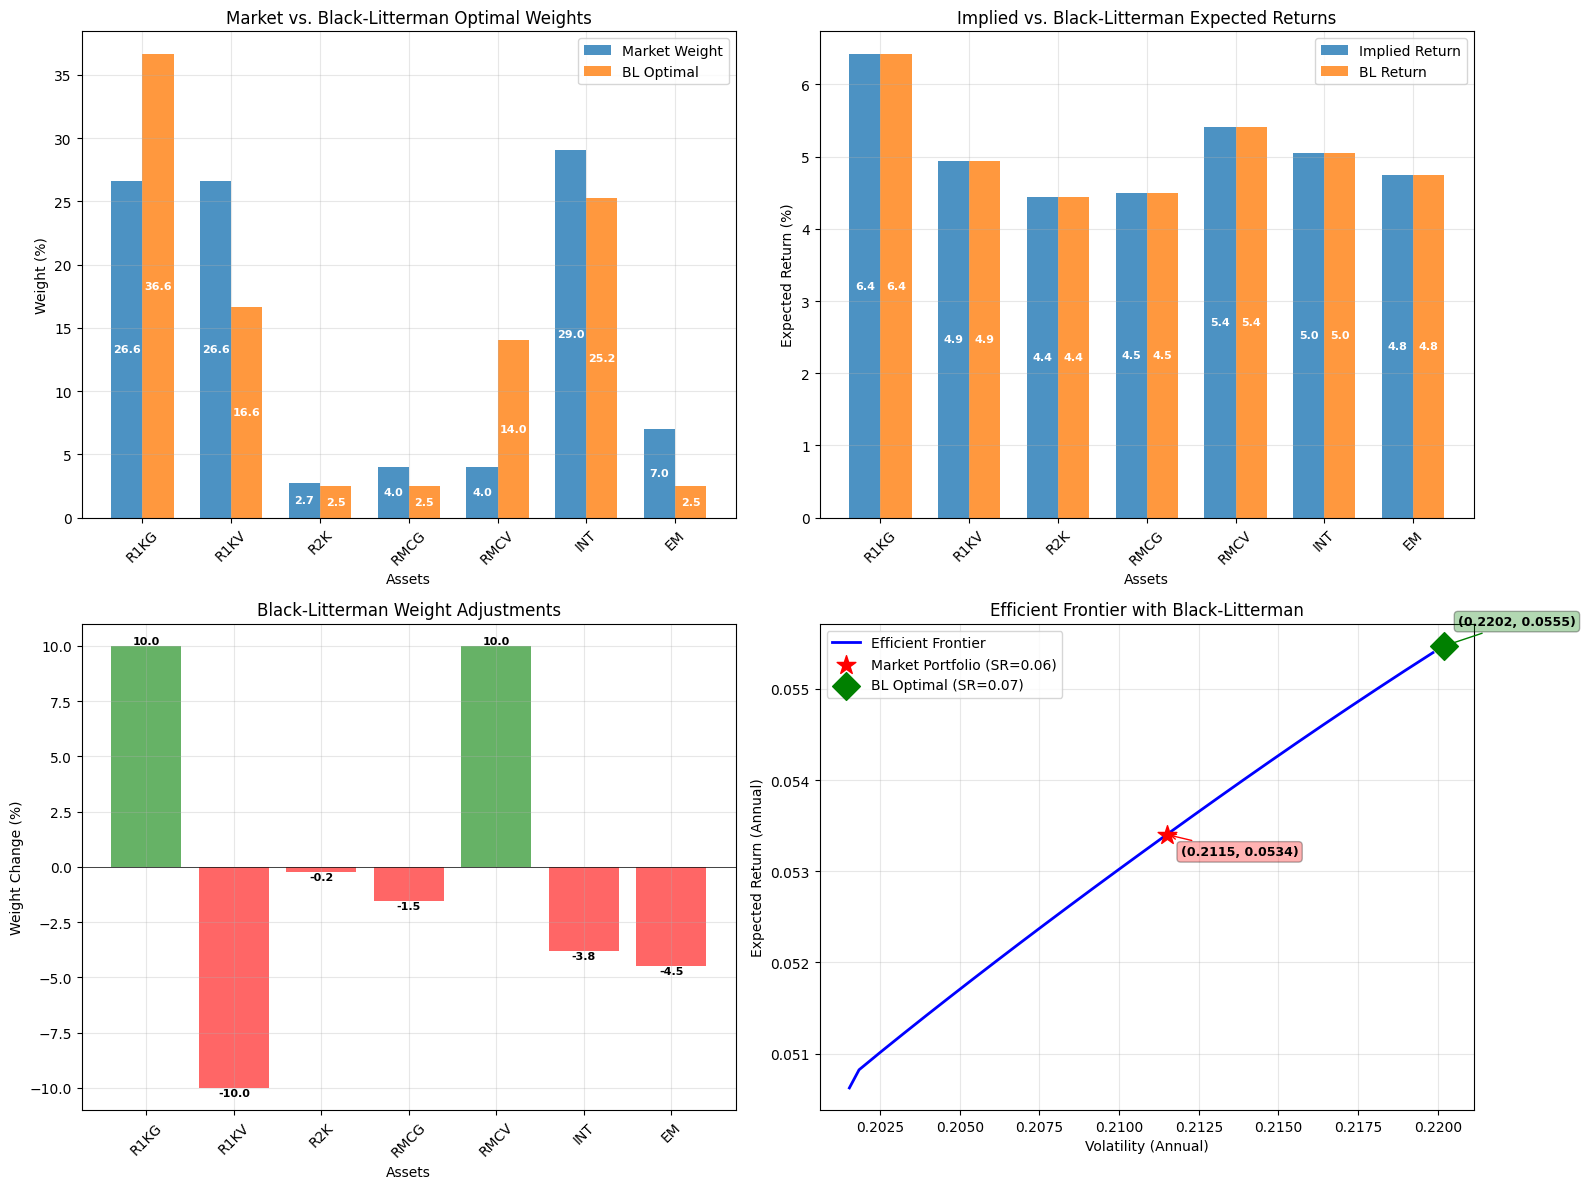

In [134]:
# Step 6: Visualize Results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Weight Comparison
ax1 = axes[0, 0]
x = np.arange(len(ticker_list))
width = 0.35
bars1 = ax1.bar(x - width/2, df_allocations['Market Weight (%)'], width, label='Market Weight', alpha=0.8)
bars2 = ax1.bar(x + width/2, df_allocations['BL Optimal Weight (%)'], width, label='BL Optimal', alpha=0.8)

# Annotate market weight bars
for i, (bar, val) in enumerate(zip(bars1, df_allocations['Market Weight (%)'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height/2, f'{val:.1f}',
             ha='center', va='center', fontsize=8, color='white', fontweight='bold')

# Annotate BL optimal weight bars
for i, (bar, val) in enumerate(zip(bars2, df_allocations['BL Optimal Weight (%)'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height/2, f'{val:.1f}',
             ha='center', va='center', fontsize=8, color='white', fontweight='bold')

ax1.set_xlabel('Assets')
ax1.set_ylabel('Weight (%)')
ax1.set_title('Market vs. Black-Litterman Optimal Weights')
ax1.set_xticks(x)
ax1.set_xticklabels(ticker_list, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Return Comparison
ax2 = axes[0, 1]
bars3 = ax2.bar(x - width/2, df_allocations['Implied Return (%)'], width, label='Implied Return', alpha=0.8)
bars4 = ax2.bar(x + width/2, df_allocations['BL Expected Return (%)'], width, label='BL Return', alpha=0.8)

# Annotate implied return bars
for i, (bar, val) in enumerate(zip(bars3, df_allocations['Implied Return (%)'])):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height/2, f'{val:.1f}',
             ha='center', va='center', fontsize=8, color='white', fontweight='bold')

# Annotate BL return bars
for i, (bar, val) in enumerate(zip(bars4, df_allocations['BL Expected Return (%)'])):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height/2, f'{val:.1f}',
             ha='center', va='center', fontsize=8, color='white', fontweight='bold')

ax2.set_xlabel('Assets')
ax2.set_ylabel('Expected Return (%)')
ax2.set_title('Implied vs. Black-Litterman Expected Returns')
ax2.set_xticks(x)
ax2.set_xticklabels(ticker_list, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Weight Changes
ax3 = axes[1, 0]
colors = ['green' if x > 0 else 'red' for x in df_allocations['Weight Change (%)']]
bars5 = ax3.bar(ticker_list, df_allocations['Weight Change (%)'], color=colors, alpha=0.6)

# Annotate weight change bars
for i, (bar, val) in enumerate(zip(bars5, df_allocations['Weight Change (%)'])):
    height = bar.get_height()
    # Position text based on positive or negative values
    if height >= 0:
        va = 'bottom'
        y_pos = height
    else:
        va = 'top'
        y_pos = height
    ax3.text(bar.get_x() + bar.get_width()/2., y_pos, f'{val:.1f}',
             ha='center', va=va, fontsize=8, fontweight='bold')

ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xlabel('Assets')
ax3.set_ylabel('Weight Change (%)')
ax3.set_title('Black-Litterman Weight Adjustments')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# 4. Efficient Frontier
ax4 = axes[1, 1]

# Generate efficient frontier
n_portfolios = 100
target_returns = np.linspace(BL_mean.min(), BL_mean.max(), n_portfolios)
efficient_portfolios = []

for target in target_returns:
    constraints_ef = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x, target=target: x.T @ BL_mean - target}
    ]
    
    result_ef = minimize(
        lambda x: np.sqrt(x.T @ Sigma @ x),
        initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints_ef,
        options={'ftol': 1e-9, 'maxiter': 1000}
    )
    
    if result_ef.success:
        vol = np.sqrt(result_ef.x.T @ Sigma @ result_ef.x)
        efficient_portfolios.append((vol, target))

if efficient_portfolios:
    vols, rets = zip(*efficient_portfolios)
    ax4.plot(vols, rets, 'b-', linewidth=2, label='Efficient Frontier')

# Plot portfolios
ax4.scatter(market_vol_bl, market_return_bl, s=200, c='red', marker='*', 
            label=f'Market Portfolio (SR={market_sharpe_bl:.2f})', zorder=5)
ax4.scatter(optimal_vol, optimal_return, s=200, c='green', marker='D', 
            label=f'BL Optimal (SR={optimal_sharpe:.2f})', zorder=5)

# Annotate market portfolio
ax4.annotate(f'({market_vol_bl:.4f}, {market_return_bl:.4f})',
             xy=(market_vol_bl, market_return_bl),
             xytext=(10, -15), textcoords='offset points',
             fontsize=9, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='red'))

# Annotate BL optimal portfolio
ax4.annotate(f'({optimal_vol:.4f}, {optimal_return:.4f})',
             xy=(optimal_vol, optimal_return),
             xytext=(10, 15), textcoords='offset points',
             fontsize=9, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='green'))

ax4.set_xlabel('Volatility (Annual)')
ax4.set_ylabel('Expected Return (Annual)')
ax4.set_title('Efficient Frontier with Black-Litterman')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()

if views == {}:
    plt.savefig("./img/black_litterman_no_views.png", dpi=300)
else:
    plt.savefig("./img/black_litterman_with_views.png", dpi=300)
# plt.show()
